<a href="https://colab.research.google.com/github/mmilannaik/Campus-DL/blob/main/gre_admission_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'graduate-admissions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F14872%2F228180%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240909%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240909T060720Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1b36343231e5c4accab9fdbcc9ef634d068bb18a744507d852f57d7049f7709d77c5db20584f4a5764210767ce2c51a4f163453359da3cc0f4ce2970fe1ac2a5fe839c13b80ab1fad7d9ca78ddc2d0c38b9d9d9a53f97591f3404ab7eb9df5aa6186f3e1dbadc7ceb176300b77812840fe12cdd5d0c00c28dc5f2b4675af87af6b146b41914088ea51506ecea849cfbab42b63ed8267176aeab11fe5286ad3fb8660813b648030a894e21f984ad42c4856c68daf3ff93197eaa85c90a3169fa187d6a846528cefcd5e20137561f2e0fda52767a42d30be432b6030ad7a90ac11b7c6da20846c3ec0b71d808f729a4cd2051ae26f9e774ebcfd312e5aa614dbb8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 9867 bytes downloaded
Downloaded and uncompressed: graduate-admissions
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/graduate-admissions/Admission_Predict.csv
/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv


In [3]:
df = pd.read_csv('/kaggle/input/graduate-admissions/Admission_Predict_Ver1.1.csv')

In [4]:
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
df.shape

(500, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [7]:
df.duplicated().sum()

0

In [8]:
df.drop(columns=['Serial No.'],inplace=True)

In [9]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [10]:
X = df.iloc[:,0:-1]
y = df.iloc[:,-1]

In [11]:
X

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0
...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1
496,337,117,5,5.0,5.0,9.87,1
497,330,120,5,4.5,5.0,9.56,1
498,312,103,4,4.0,5.0,8.43,0


In [12]:
y

,Chance of Admit
0,0.92
1,0.76
2,0.72
3,0.80
4,0.65
...,...
495,0.87
496,0.96
497,0.93
498,0.73


In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [14]:
X_train

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
238,310,104,3,2.0,3.5,8.37,0
438,318,110,1,2.5,3.5,8.54,1
475,300,101,3,3.5,2.5,7.88,0
58,300,99,1,3.0,2.0,6.80,1
380,322,104,3,3.5,4.0,8.84,1
...,...,...,...,...,...,...,...
255,307,110,4,4.0,4.5,8.37,0
72,321,111,5,5.0,5.0,9.45,1
396,325,107,3,3.0,3.5,9.11,1
235,326,111,5,4.5,4.0,9.23,1


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
X_train_scaled

array([[0.4       , 0.42857143, 0.5       , ..., 0.57142857, 0.50320513,
        0.        ],
       [0.56      , 0.64285714, 0.        , ..., 0.57142857, 0.55769231,
        1.        ],
       [0.2       , 0.32142857, 0.5       , ..., 0.28571429, 0.34615385,
        0.        ],
       ...,
       [0.7       , 0.53571429, 0.5       , ..., 0.57142857, 0.74038462,
        1.        ],
       [0.72      , 0.67857143, 1.        , ..., 0.71428571, 0.77884615,
        1.        ],
       [0.2       , 0.46428571, 0.        , ..., 0.14285714, 0.32051282,
        0.        ]])

In [18]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense

In [19]:
model = Sequential()

model.add(Dense(7,activation='relu',input_dim=7))
model.add(Dense(7,activation='relu'))
model.add(Dense(1,activation='linear'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │              56 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120 (480.00 B)

 Trainable params: 120 (480.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss='mean_squared_error',optimizer='Adam')

In [23]:
history = model.fit(X_train_scaled,y_train,epochs=100,validation_split=0.2)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4637 - val_loss: 0.4719
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4189 - val_loss: 0.4182
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3609 - val_loss: 0.3624
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3041 - val_loss: 0.3031
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2487 - val_loss: 0.2402
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2004 - val_loss: 0.1783
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1479 - val_loss: 0.1225
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1002 - val_loss: 0.0771
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0558 - val_loss: 0.0455
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0300 - val_loss: 0.0272
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0191 - val_loss: 0.0188
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [26]:
y_pred = model.predict(X_test_scaled)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [27]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.8127276452258655

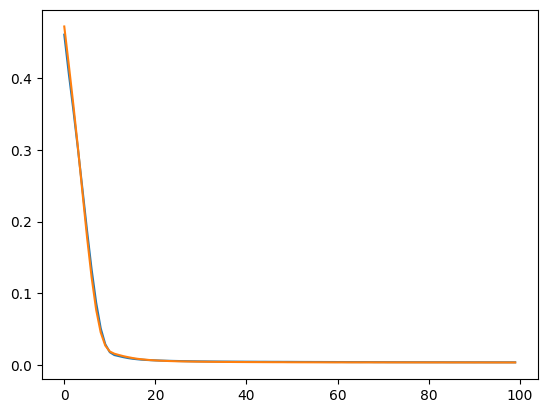

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])